# Bayesian Model Comparison on Gaussian Processes

This notebook demonstrates how to perform Bayesian model comparison with the `compass` package on the example of Gaussian processes.

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "4,5,6"

In [2]:
from compass import ScoreBasedInferenceModel as SBIm
from compass import ModelTransfuser as MTf

In [3]:
import torch

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Hypothesis 1
$$ \begin{align*}
    \theta_1 &\sim \mathcal{N}(0, 3^2) \\
    x_1 &\sim \mathcal{N}(2 \cdot \sin(\theta_1), 0.5^2) \\
    x_2 &\sim \mathcal{N}(0.1 \cdot \theta_1^2, (0.5 \cdot |x_1|)^2)
\end{align*} $$

In [4]:
def gen_data_hyp1(int):
    theta1 = 3 * torch.randn(int)
    x1 = 2 * torch.sin(theta1) + torch.randn(int) * 0.5
    x2 = 0.1 * theta1**2 + 0.5*torch.abs(x1) * torch.randn(int)

    return theta1.unsqueeze(1), torch.stack([x1, x2],dim=1)

In [5]:
theta1, x1 = gen_data_hyp1(100_000)
val_theta1, val_x1 = gen_data_hyp1(1_000)

nodes_max = theta1.shape[1] + x1.shape[1]

## Hypothesis 2
$$ \begin{align*}
    \theta_1 &\sim \mathcal{N}(0, 3^2) \\
    x_1 &\sim \mathcal{N}(2 \cdot \cos(\theta_1), 0.5^2) \\
    x_2 &\sim \mathcal{N}(0.1 \cdot \theta_1^2, (0.5 \cdot |x_1|)^2)
\end{align*} $$

In [6]:
def gen_data_hyp2(int):
    theta1 = 3 * torch.randn(int)
    x1 = 2 * torch.cos(theta1) + torch.randn(int) * 0.5
    x2 = 0.1 * theta1**2 + 0.5*torch.abs(x1) * torch.randn(int)

    return theta1.unsqueeze(1), torch.stack([x1, x2],dim=1)

In [7]:
theta2, x2 = gen_data_hyp2(100_000)
val_theta2, val_x2 = gen_data_hyp2(1_000)

## Hypothesis 3
$$ \begin{align*}
    \theta_1 &\sim \mathcal{N}(0, 3^2) \\
    x_1 &\sim \mathcal{N}(2\cdot \tan(\theta_1), 0.5^2) \\
    x_2 &\sim \mathcal{N}(0.1\cdot\theta_1^2, (0.5\cdot |x_1|)^2)
\end{align*} $$

In [43]:
def gen_data_hyp3(int):
    theta1 = 3 * torch.randn(int)
    x1 = 2 * torch.cos(theta1-torch.pi/4) + torch.randn(int) * 0.5
    x2 = 0.05 * theta1**3 + 0.5*torch.abs(x1) * torch.randn(int)

    return theta1.unsqueeze(1), torch.stack([x1, x2],dim=1)

In [44]:
theta3, x3 = gen_data_hyp3(100_000)
val_theta3, val_x3 = gen_data_hyp3(1_000)

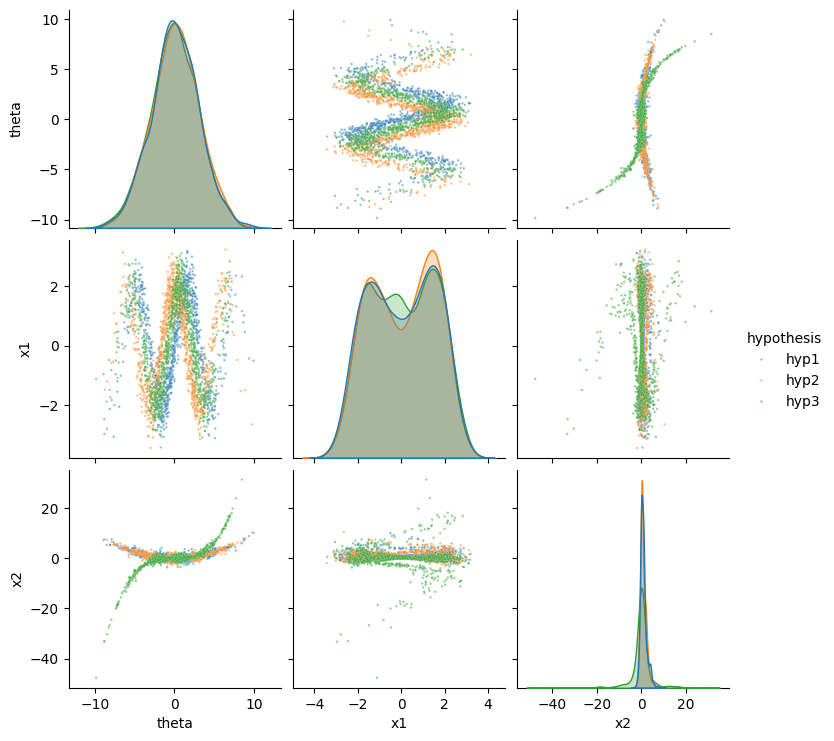

In [45]:
df1 = pd.DataFrame(torch.concatenate([val_theta1, val_x1], dim=1).numpy(), columns=['theta', 'x1', 'x2'])
df2 = pd.DataFrame(torch.concatenate([val_theta2, val_x2], dim=1).numpy(), columns=['theta', 'x1', 'x2'])
df3 = pd.DataFrame(torch.concatenate([val_theta3, val_x3], dim=1).numpy(), columns=['theta', 'x1', 'x2'])

df1["hypothesis"] = "hyp1"
df2["hypothesis"] = "hyp2"
df3["hypothesis"] = "hyp3"

combined_df = pd.concat([df1, df2, df3], axis=0)

sns.pairplot(combined_df, diag_kind='kde', hue='hypothesis', plot_kws=dict(alpha=0.5, s=3))
plt.show()

In [46]:
mtf = MTf(path="data/tutorial_Gaussians")

In [47]:
#mtf.add_data("Hypothesis 1", theta1, x1, val_theta1, val_x1)
#mtf.add_data("Hypothesis 2", theta2, x2, val_theta2, val_x2)
mtf.add_data("Hypothesis 3", theta3, x3, val_theta3, val_x3)

Data added to model Hypothesis 3


In [48]:
mtf.init_models(sde_type="vesde", sigma=3, depth=4, num_heads=24, hidden_size=168, mlp_ratio=5)

Models initialized: ['Hypothesis 3']


In [49]:
sum(p.numel() for p in mtf.models_dict["Hypothesis 1"].parameters())

KeyError: 'Hypothesis 1'

In [50]:
mtf.train_models(verbose=False, batch_size=256)

Model Hypothesis 3 trained


In [51]:
sbim1 = SBIm.load("data/tutorial_Gaussians/Hypothesis 1_checkpoint.pt", device="cuda")
sbim2 = SBIm.load("data/tutorial_Gaussians/Hypothesis 2_checkpoint.pt", device="cuda")
# sbim3 = SBIm.load("data/tutorial_Gaussians/Hypothesis 3_checkpoint.pt", device="cuda")

mtf.add_model("Hypothesis 1", sbim1)
mtf.add_model("Hypothesis 2", sbim2)
# mtf.add_model("Hypothesis 3", sbim3)

Model Hypothesis 1 added to transfuser.
Model Hypothesis 2 added to transfuser.


In [52]:
# Create test data
test_theta1, test_x1 = gen_data_hyp1(100)

# Compare models on test data
mtf.compare(x=test_x1, device="cuda", timesteps=100, method="dpm", order=1)

Probabilities of the models after 100 observations:
Hypothesis 3: 100.00 %
Hypothesis 1:   0.00 %
Hypothesis 2:   0.00 %

Model Hypothesis 3 fits the data best with a relative support of 100.0% among the considered models and could reject the null hypothesis decisively.


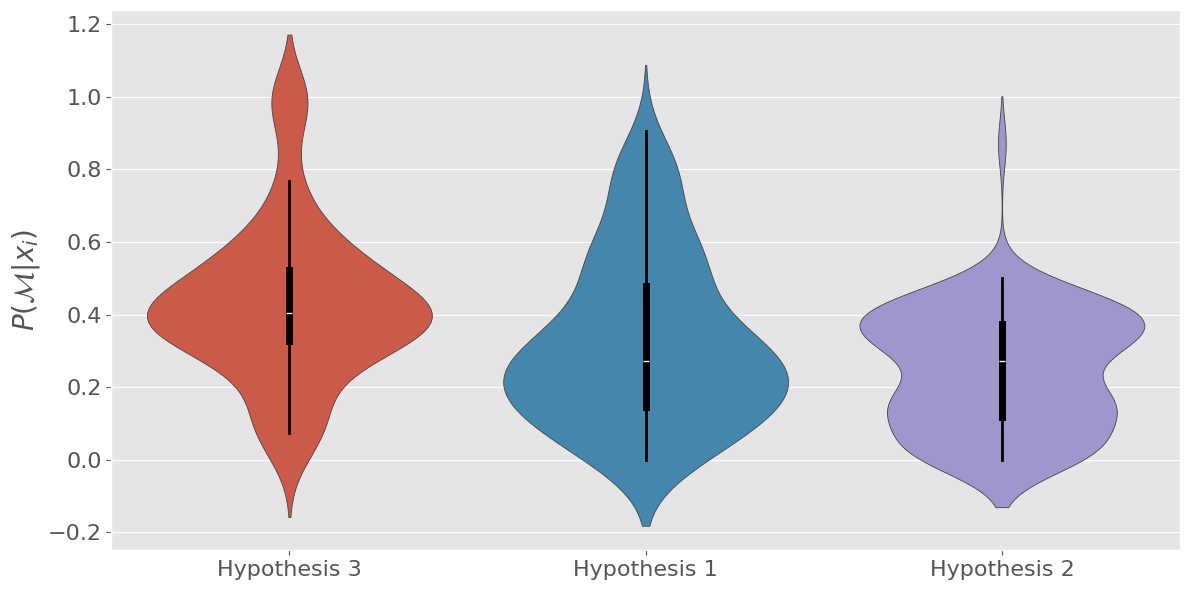

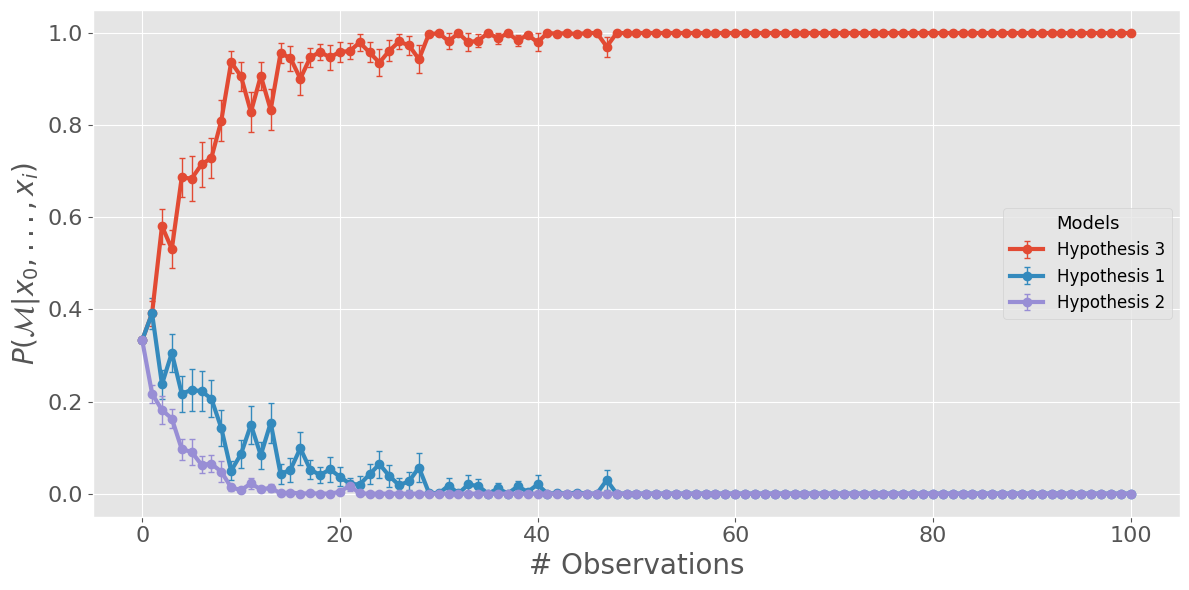

In [53]:
mtf.plot_comparison()

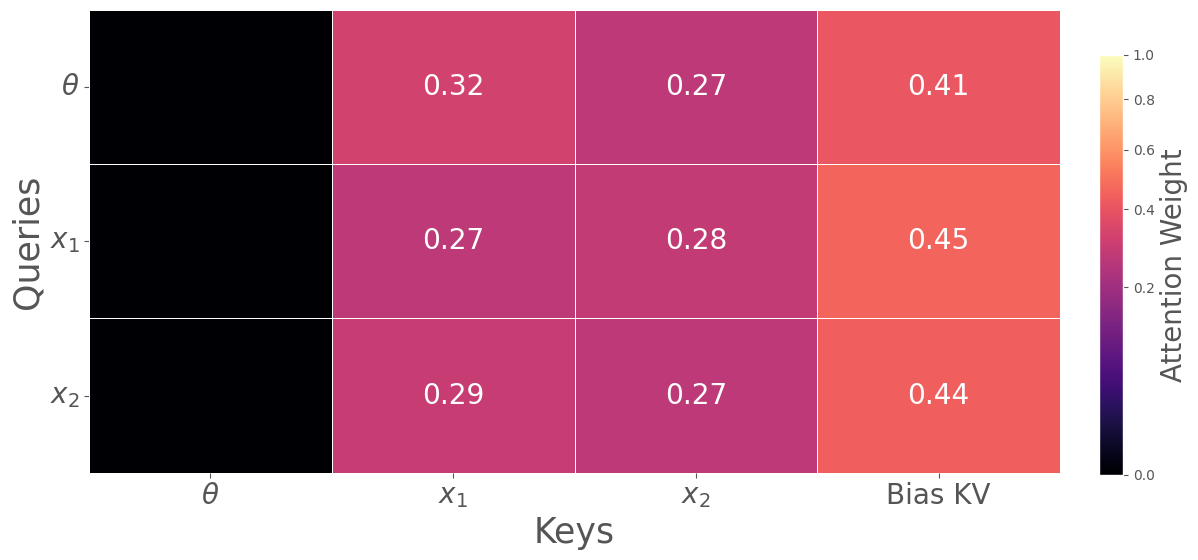

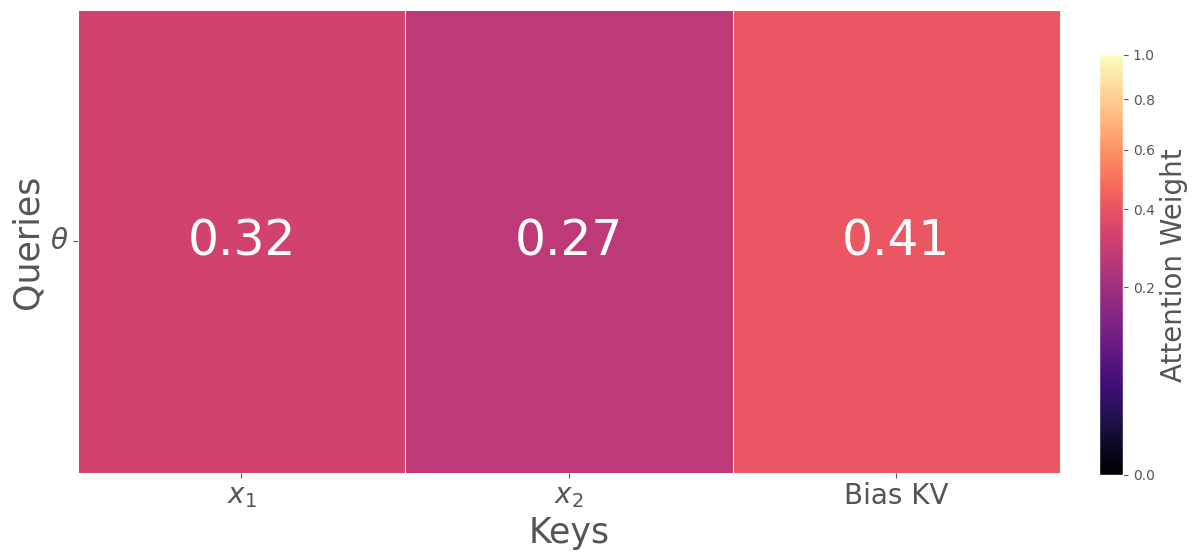

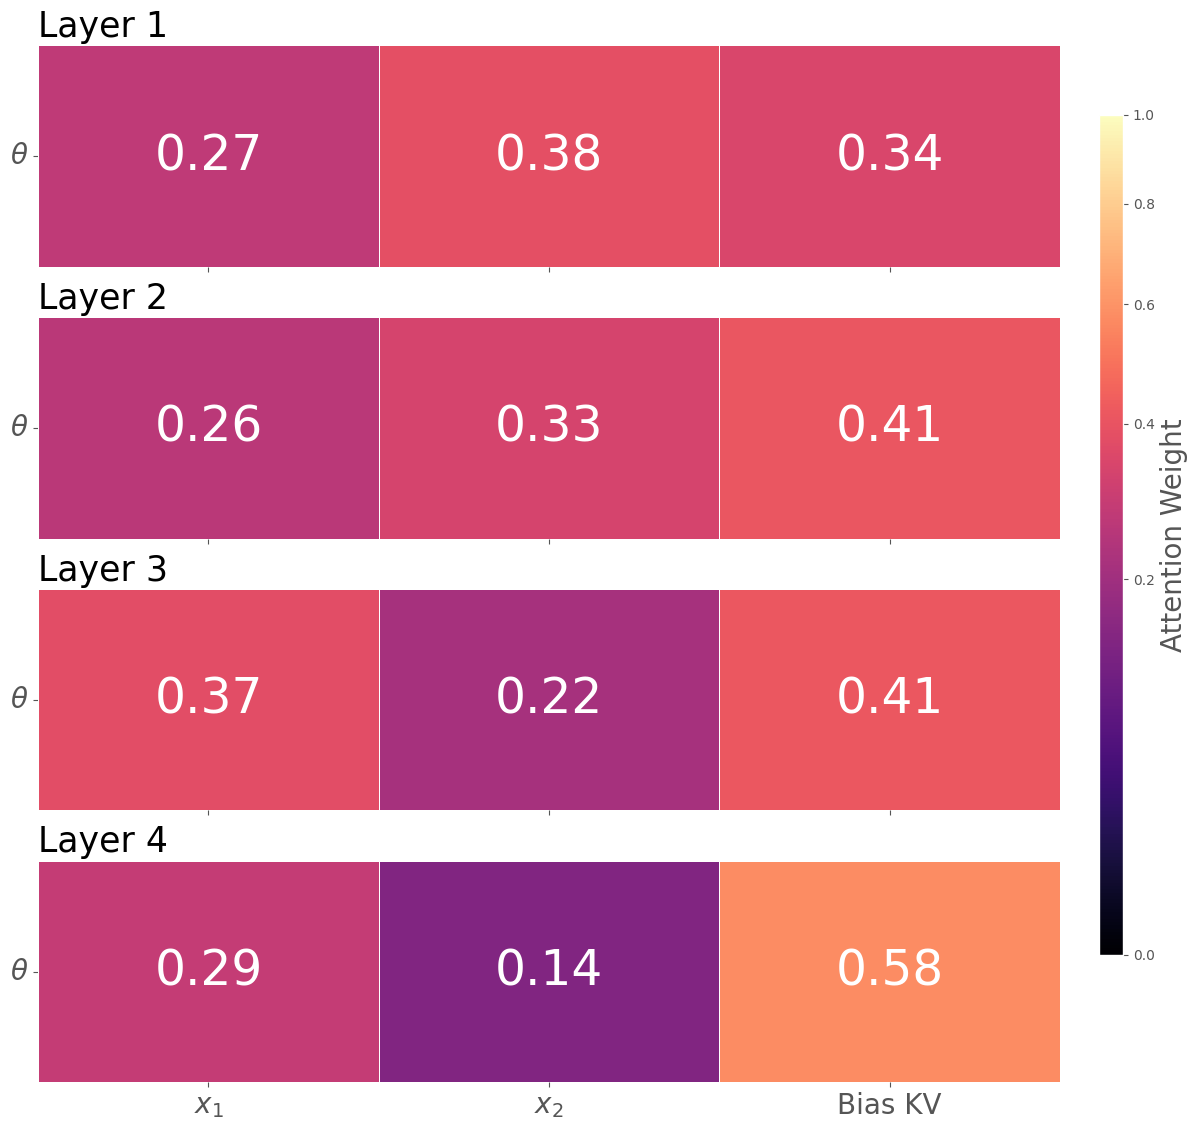

In [54]:
mtf.plot_attention(labels=[r"$\theta$", r"$x_1$", r"$x_2$"])

In [55]:
import pickle

with open("data/tutorial_Gaussians/model_comp.pkl", "rb") as f:
    results = pickle.load(f)

In [56]:
100*((test_theta1- results["Hypothesis 1"]["MAP"][:,0]).abs()/test_theta1.abs()).mean()

tensor(84.8660, dtype=torch.float64)

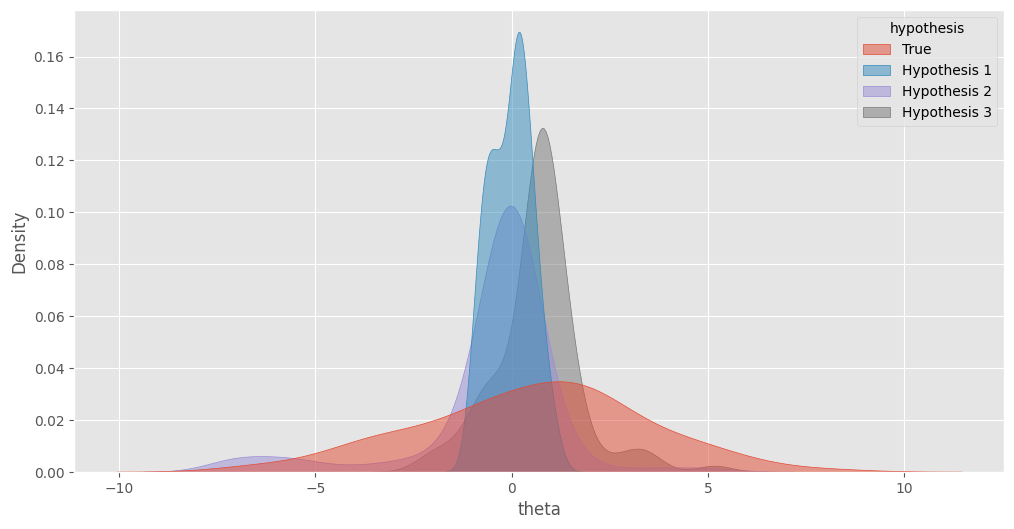

In [57]:
df_theta_test = pd.DataFrame(test_theta1.numpy(), columns=["theta"])
df_theta_test["hypothesis"] = "True"
df_theta1_hat = pd.DataFrame(results["Hypothesis 1"]["MAP"][:,0], columns=["theta"])
df_theta1_hat["hypothesis"] = "Hypothesis 1"
df_theta2_hat = pd.DataFrame(results["Hypothesis 2"]["MAP"][:,0], columns=["theta"])
df_theta2_hat["hypothesis"] = "Hypothesis 2"
df_theta3_hat = pd.DataFrame(results["Hypothesis 3"]["MAP"][:,0], columns=["theta"])
df_theta3_hat["hypothesis"] = "Hypothesis 3"

df_maps = pd.concat([df_theta_test, df_theta1_hat, df_theta2_hat, df_theta3_hat], axis=0)

plt.style.use('ggplot')
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df_maps, x="theta", hue="hypothesis", fill=True, alpha=0.5)
plt.show()

In [58]:
results["Hypothesis 1"]["attn_weights"].mean(0)

tensor([[0.0000, 0.3016, 0.3146, 0.3838],
        [0.0000, 0.1733, 0.2865, 0.5402],
        [0.0000, 0.2429, 0.2001, 0.5570]])

In [56]:
results["Hypothesis 3"]["attn_weights"]

tensor([[[0.0000, 0.3611, 0.3018, 0.3371],
         [0.0000, 0.3113, 0.3432, 0.3455],
         [0.0000, 0.3496, 0.2974, 0.3530]],

        [[0.0000, 0.2863, 0.2201, 0.4936],
         [0.0000, 0.3237, 0.1143, 0.5619],
         [0.0000, 0.3059, 0.1721, 0.5220]],

        [[0.0000, 0.3373, 0.2843, 0.3784],
         [0.0000, 0.3220, 0.1771, 0.5008],
         [0.0000, 0.2807, 0.2374, 0.4819]],

        [[0.0000, 0.3223, 0.2705, 0.4072],
         [0.0000, 0.2403, 0.1507, 0.6090],
         [0.0000, 0.2852, 0.1974, 0.5175]],

        [[0.0000, 0.3425, 0.3818, 0.2757],
         [0.0000, 0.2678, 0.4414, 0.2909],
         [0.0000, 0.4250, 0.3475, 0.2274]],

        [[0.0000, 0.3447, 0.2799, 0.3754],
         [0.0000, 0.5246, 0.1106, 0.3648],
         [0.0000, 0.5741, 0.1302, 0.2957]],

        [[0.0000, 0.3083, 0.3240, 0.3677],
         [0.0000, 0.2180, 0.3384, 0.4436],
         [0.0000, 0.4590, 0.2416, 0.2995]],

        [[0.0000, 0.3101, 0.3618, 0.3281],
         [0.0000, 0.1540, 0.4536, 0.3924

In [57]:
results["Hypothesis 1"]

{'attn_weights': tensor([[[0.0000, 0.3571, 0.3118, 0.3310],
          [0.0000, 0.2920, 0.3164, 0.3916],
          [0.0000, 0.3727, 0.2784, 0.3490]],
 
         [[0.0000, 0.2724, 0.3096, 0.4179],
          [0.0000, 0.1104, 0.2420, 0.6476],
          [0.0000, 0.2163, 0.2135, 0.5702]],
 
         [[0.0000, 0.3843, 0.3008, 0.3149],
          [0.0000, 0.1140, 0.2233, 0.6628],
          [0.0000, 0.1828, 0.1640, 0.6532]],
 
         [[0.0000, 0.2702, 0.2332, 0.4966],
          [0.0000, 0.1308, 0.1359, 0.7333],
          [0.0000, 0.1335, 0.1529, 0.7136]],
 
         [[0.0000, 0.3398, 0.3573, 0.3029],
          [0.0000, 0.2760, 0.4013, 0.3227],
          [0.0000, 0.4177, 0.2839, 0.2984]],
 
         [[0.0000, 0.2568, 0.3567, 0.3866],
          [0.0000, 0.0963, 0.3354, 0.5683],
          [0.0000, 0.3810, 0.2076, 0.4114]],
 
         [[0.0000, 0.2581, 0.2505, 0.4914],
          [0.0000, 0.0926, 0.1357, 0.7717],
          [0.0000, 0.1645, 0.0751, 0.7605]],
 
         [[0.0000, 0.1807, 0.2972, 0.52